# Experiment 1

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
def load_spectrum(fname):
    '''
    Read spectrum from CSV
    '''
    
    with open(fname ,"r") as f:
        for x, line in enumerate(f):
            if(line == 'Channel Data:\n'):
                data_start = x+2
                break
    
    data = np.loadtxt(fname, unpack=True, skiprows=data_start, delimiter= ",", usecols=[0, 1, 2])

    channel = data[0]
    counts = data[-1]
    dcounts = np.sqrt(counts)
    for i, value in enumerate(dcounts):
        if value == 0: dcounts[i] = 1.14
    
    energy = data[1] if data.shape[0] > 2 else None
    
    return channel, energy, counts, dcounts

In [3]:
def gaussianfunc(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))

def linearfunc(p,x):
    return p[0]*x + p[1]

def gaussianlinear(p,x):
    return gaussianfunc(p[0:3],x) + linearfunc(p[3:5],x)

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def exponential(p, x):
    return p[0] * np.exp(-p[1] * x)

In [4]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

## Spectrum Identification and Fitting

In [244]:
spectrum_fname = 'cs137.csv'
spectrum_label = 'Cs-137'

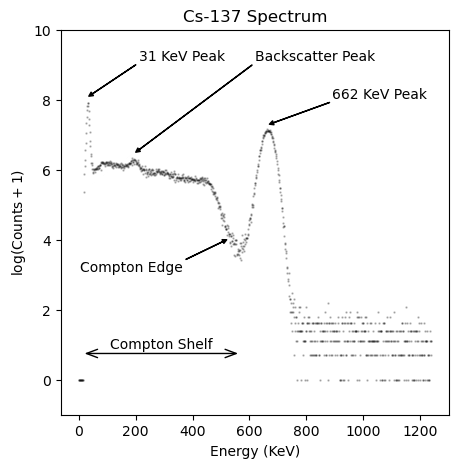

In [281]:
import matplotlib.patches as mpatches

channel, energy, counts, dcounts = load_spectrum(spectrum_fname)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(energy, np.log(counts + 1), marker='.', color='black', s=2, alpha=0.25, label='Data')

ax.set_ylim((-1, 10))
ax.set_xlim((None, 1300))

arr = mpatches.FancyArrowPatch((10, 0.75), (570, 0.75), arrowstyle='<->, head_width=.15', mutation_scale=20)
ax.add_patch(arr)
ax.annotate("Compton Shelf", (.5, .7), xycoords=arr, ha='center', va='bottom')

ax.annotate('31 KeV Peak', xy=(35, 8.1), xytext=(0.2, 0.95), 
            xycoords='data', textcoords='axes fraction', va='top', ha='left',
            arrowprops=dict(facecolor='black', width=0.1, headwidth=3, headlength=3))
ax.annotate('662 KeV Peak', xy=(670, 7.3), xytext=(0.7, 0.85), 
            xycoords='data', textcoords='axes fraction', va='top', ha='left',
            arrowprops=dict(facecolor='black', width=0.1, headwidth=3, headlength=3))
ax.annotate('Backscatter Peak', xy=(200, 6.5), xytext=(0.5, 0.95), 
            xycoords='data', textcoords='axes fraction', va='top', ha='left',
            arrowprops=dict(facecolor='black', width=0.1, headwidth=3, headlength=3))
ax.annotate('Compton Edge', xy=(520, 4), xytext=(0.05, 0.4), 
            xycoords='data', textcoords='axes fraction', va='top', ha='left',
            arrowprops=dict(facecolor='black', width=0.1, headwidth=3, headlength=3))

ax.set_xlabel('Energy (KeV)')
ax.set_ylabel('$\\log(\\text{Counts} + 1)$')
ax.set_title(spectrum_label + ' Spectrum')
#ax.legend()

plt.savefig('figures/cs137-spectrum.pdf')

In [341]:
fit_regions = [(30, 85)]

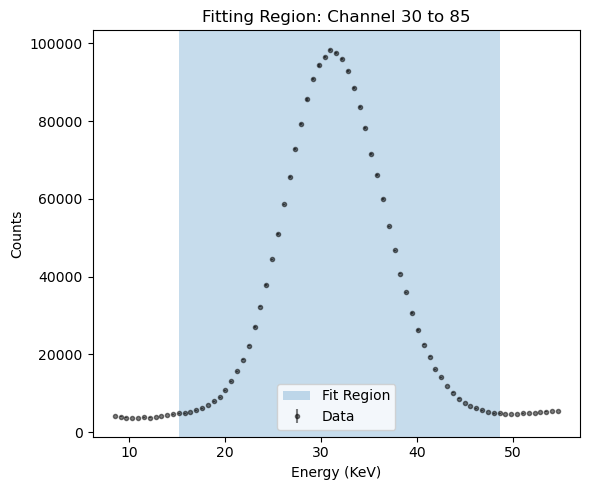

In [342]:
fig, axs = plt.subplots(1, len(fit_regions), figsize=(6 * len(fit_regions), 5))
if len(fit_regions) == 1: axs = [axs]

for ax, (min_x, max_x) in zip(axs, fit_regions):

    padding = (max_x - min_x) // 5
    padded_min_x = max(0, min_x - padding)
    padded_max_x = min(energy.shape[0], max_x + padding)
    
    ax.errorbar(
        energy[padded_min_x: padded_max_x], 
        counts[padded_min_x: padded_max_x], 
        dcounts[padded_min_x: padded_max_x], 
        fmt='k.', alpha=0.5, label='Data'
    )

    parameters_i = [
        10000, 
        (min_x + max_x) // 2, 
        max_x - min_x, 
        0, 0
    ]

    ax.axvspan(energy[min_x], energy[max_x], label='Fit Region', alpha=0.25)

    ax.set_xlabel('Energy (KeV)')
    ax.set_ylabel('Counts')
    ax.set_title(f'Fitting Region: Channel {min_x} to {max_x}')
    ax.legend()

plt.tight_layout()

[982480.0, 31.0, 8.0, 0, 10]

Converged with chi-squared 1406.51
Number of degrees of freedom, dof = 50.00
Reduced chi-squared 28.13

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 9.825e+05                | 1.169e+06                | 1.179e+03               
1           | 3.100e+01                | 3.143e+01                | 4.614e-03               
2           | 8.000e+00                | 5.024e+00                | 4.679e-03               
3           | 0.000e+00                | 3.593e+01                | 1.410e+00               
4           | 1.000e+01                | 3.386e+03                | 5.180e+01               


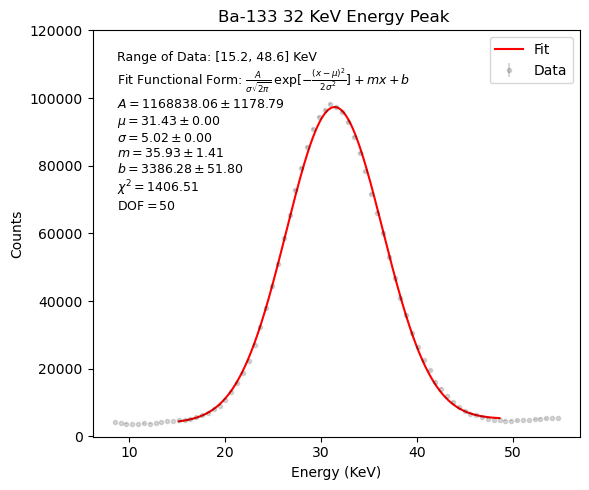

In [345]:
fig, axs = plt.subplots(1, len(fit_regions), figsize=(6 * len(fit_regions), 5))
if len(fit_regions) == 1: axs = [axs]

for ax, (min_x, max_x) in zip(axs, fit_regions):

    padding = (max_x - min_x) // 5
    padded_min_x = max(0, min_x - padding)
    padded_max_x = min(channel.shape[0], max_x + padding)
    
    ax.errorbar(
        energy[padded_min_x: padded_max_x], 
        counts[padded_min_x: padded_max_x], 
        dcounts[padded_min_x: padded_max_x], 
        fmt='k.', alpha=0.15, label='Data'
    )

    params_i = [
        counts[min_x : max_x].max() * 10, 
        (energy[min_x] + energy[max_x]) // 2, 
        (energy[max_x] - energy[min_x]) // 4, 
        0, 
        10
    ]

    print(params_i)

    params_f, params_err, chisq, dof = data_fit(
        params_i, 
        gaussianlinear, 
        energy[min_x : max_x], 
        counts[min_x : max_x], 
        dcounts[min_x : max_x]
    )

    linspace = np.linspace(energy[min_x], energy[max_x], 1000)

    ax.plot(linspace, gaussianlinear(params_f, linspace), label='Fit', color='r')

    txt = 'Range of Data: [{:.1f}, {:.1f}] KeV \n'.format(energy[min_x], energy[max_x])
    txt += 'Fit Functional Form: $\\frac{A}{\\sigma \\sqrt{2 \\pi}} \\: \\exp[- \\frac{(x - \\mu)^2}{2 \\sigma^2}] + mx + b$ \n'
    txt += '$A = {:.2f} \\pm {:.2f}$ \n'.format(params_f[0], params_err[0])
    txt += '$\\mu = {:.2f} \\pm {:.2f}$ \n'.format(params_f[1], params_err[1])
    txt += '$\\sigma = {:.2f} \\pm {:.2f}$ \n'.format(params_f[2], params_err[2])
    txt += '$m = {:.2f} \\pm {:.2f}$ \n'.format(params_f[3], params_err[3])
    txt += '$b = {:.2f} \\pm {:.2f}$ \n'.format(params_f[4], params_err[4])
    txt += '$\\chi^2 = {:.2f}$ \n'.format(chisq)
    txt += 'DOF$ = {}$'.format(dof)
    ax.text(0.05, 0.95, txt, transform=ax.transAxes , fontsize=9, verticalalignment='top')

    ax.set_ylim([-100, 120000])
    ax.set_xlabel('Energy (KeV)')
    ax.set_ylabel('Counts')
    ax.set_title(f'Ba-133 32 KeV Energy Peak ')
    ax.legend()

plt.tight_layout()
#plt.savefig('figures/ba133-32-fit.pdf')

# Task 5

In [282]:
# CS 137 662 KeV
x_cs662 = np.array([0.4, 0.8, 1.6, 0.2, 0.1, 3.2, 3.2, 0.2, 0.1]) / 100 # Meters
t_cs662 = np.array([182, 148, 146, 130, 114, 125, 302, 180, 195]) # Seconds

x_cs31 = np.array([0.2, 0.1, 0.4, 0.8, 1.6, 6.5]) / 100 # Meters
t_cs31 = np.array([123, 120, 125, 121, 128, 184]) # Seconds

net_cs = {
    31: np.array([678, 903, 583, 372, 129, 15]), 
    662: np.array([12847, 9955, 8276, 9764, 8511, 5287, 12639, 13706, 14600])
}

gross_cs = {
    31: np.array([4032, 2839, 2078, 1498, 1137, 1063]), 
    662: np.array([12847, 9955, 8276, 9764, 8511, 5287, 12639, 13706, 14600])
}

In [283]:
# Na 22 511 and 1275 KeV
x_na = np.array([0.4, 0.8, 1.6, 0.1, 3.2, 0.2]) / 100
t_na = np.array([123, 123, 121, 122, 123, 119])

net_na = {
    511: np.array([42356, 37307, 31740, 43515, 22774, 41716]), 
    1275: np.array([8016, 7519, 6516, 8128, 5200, 7708])
}

gross_na = {
    511: np.array([56957, 46081, 40516, 51989, 30838, 49816]), 
    1275: np.array([8822, 8201, 7322, 9059, 6008, 8701])
}

In [285]:
# Ba 133 32, 81, 356 KeV
x_ba = np.array([0.2, 0.4, 0.8, 1.6, 3.2, 0.1]) / 100
t_ba = np.array([122, 121, 122, 121, 122, 120])

net_ba = {
    32: np.array([31161, 19399, 8021, 2945, 1126, 39364]), 
    81: np.array([22249, 19676, 16945, 12206, 4498, 22441]), 
    356: np.array([13494, 10389, 10284, 8139, 5419, 11637])
}

gross_ba = {
    32: np.array([36810, 23824, 11053, 4378, 2240, 45749]), 
    81: np.array([33914, 31147, 27116, 20657, 10709, 34632]), 
    356: np.array([27093, 23821, 22254, 18433, 12560, 24729])
}

In [333]:
x = x_ba
t = t_ba
net = net_ba[356]
gross = gross_ba[356]
title = 'Ba-133 356 KeV Photon Rate\nThrough Aluminum Absorbers'

In [334]:
dx = np.array([0.1] * len(x)) / 100 # Meters
dt = np.array([1] * len(t)) # Seconds
b = gross - net
dnet = np.sqrt(gross + b)
R = net/t
dR = (dnet/net + dt/t) * R


Converged with chi-squared 36.05
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 9.01

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.000e+02                | 1.037e+02                | 1.519e+00               
1           | 1.000e+02                | 2.675e+01                | 1.173e+00               


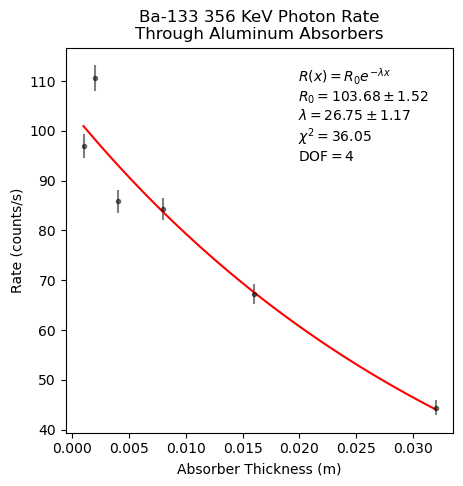

In [335]:
fig, ax = plt.subplots(figsize=(5, 5))

p0 = [300, 100]
pf, pferr, chisq, dof = data_fit(p0, exponential, x, R, dR)

ax.errorbar(x, R, dR, fmt='k.', alpha=0.5, label='Data')
x_range = np.linspace(x.min(), x.max(), 100)
ax.plot(x_range, exponential(pf, x_range), color='r', label='Fit')

txt = '$R(x) = R_0 e^{-\\lambda x}$ \n'
txt += '$R_0 = {:.2f} \\pm {:.2f}$ \n'.format(pf[0], pferr[0])
txt += '$\\lambda = {:.2f} \\pm {:.2f}$ \n'.format(pf[1], pferr[1])
txt += '$\\chi^2 = {:.2f}$ \n'.format(chisq)
txt += 'DOF$ = {}$'.format(dof)
ax.text(0.6, 0.95, txt, transform=ax.transAxes , fontsize=10, verticalalignment='top')

ax.set_xlabel('Absorber Thickness (m)')
ax.set_ylabel('Rate (counts/s)')
ax.set_title(title)
plt.savefig('figures/ba133-356-rates.pdf')